# 1. Corregir las sugerencias que recibimos de la entrega 2:

    No lematizar

Para esto simplemente omitimos el paso de lematización.

    Tokenización

Este paso lo vamos a pulir, si bien es cierto que al final no estaba mal, vistos los resultados como la cobertura de los modelos de embeddings, se puede mejorar con unos cambios.

    Análisis de longitud a nivel de token de ClinicalBERT

En la anterior entrega vimosla longitud a nivel de palabra, y en las anotaciones de la anterior entrega se nos pidió extraer los embeddings de clinicalBERT para los tokens de cada texto. Para ver si el modelo tiene contexto suficiente. 

    Mejorar Análisis Visual de los Embeddings

En la anterior entrega solo pusimos una imagen PCA de ClinicalBERT, vamos a mejorarlo.

Estos eran los resultados previos CON lemmatización y la normalización previa para los embeddings no contextuales:

In [ ]:
""" 
Total de palabras/tokens en todas las conversaciones ORIGINALMENTE: 126935
Total de tokens: 126,935

Vocabulario total: 9,496 palabras/tokens únic@s

Modelo: Word2Vec (Google News)
Palabras encontradas: 4,766/9,496 (50.19%)
Tokens cubiertos: 86,784/126,935 (68.37%)

Top 10 palabras NO encontradas (más frecuentes):
  Doctor:             :  5809 ocurrencias
  Patient:            :  4895 ocurrencias
  to                  :  2077 ocurrencias
  a                   :  1983 ocurrencias
  and                 :  1822 ocurrencias
  of                  :  1567 ocurrencias
  Guest_family:       :   559 ocurrencias
  Yes,                :   518 ocurrencias
  No,                 :   477 ocurrencias
  Yeah,               :   302 ocurrencias

Modelo: GloVe (Wiki Gigaword)
Palabras encontradas: 3,941/9,496 (41.50%)
Tokens cubiertos: 75,535/126,935 (59.51%)

Top 10 palabras NO encontradas (más frecuentes):
  Doctor:             :  5809 ocurrencias
  Patient:            :  4895 ocurrencias
  I                   :  4720 ocurrencias
  Do                  :   648 ocurrencias
  How                 :   581 ocurrencias
  Guest_family:       :   559 ocurrencias
  Yes,                :   518 ocurrencias
  What                :   507 ocurrencias
  No,                 :   477 ocurrencias
  No.                 :   443 ocurrencias

Modelo: FastText (Wiki News)
Palabras encontradas: 5,763/9,496 (60.69%)
Tokens cubiertos: 98,890/126,935 (77.91%)

Top 10 palabras NO encontradas (más frecuentes):
  Doctor:             :  5809 ocurrencias
  Patient:            :  4895 ocurrencias
  Guest_family:       :   559 ocurrencias
  Yes,                :   518 ocurrencias
  No,                 :   477 ocurrencias
  I'm                 :   441 ocurrencias
  don't               :   310 ocurrencias
  Yeah,               :   302 ocurrencias
  Well,               :   256 ocurrencias
  it's                :   249 ocurrencias

TABLA COMPARATIVA DE COBERTURA
                Modelo  Cobertura Vocabulario (%)  Cobertura Tokens (%)  Palabras Encontradas  Palabras No Encontradas
Word2Vec (Google News)                      50.19                 68.37                  4766                     4730
 GloVe (Wiki Gigaword)                      41.50                 59.51                  3941                     5555
  FastText (Wiki News)                      60.69                 77.91                  5763                     3733 """

Primero, todos los modelos tienen problemas con las palabras terminando en comas, y palabras abreviadas, por lo que las procesamos:

  yes, -> yes
  
  i'm -> i am

Además, aunque sí haciamos un  Doctor → DOC o Patient → PAT  , el marcador especial cambiaba a minuscula al final, lo arreglaremos.
También hemos encontrado otros tags como Doctor_2, guest_family y guest_clinician. Los trataremos tambien. Esperamos que estos cambios puedan mejorar el trabajo que hacen los 3 modelos.

In [1]:
# Instalación de librerías
%pip install spacy gensim transformers torch tensorflow tensorflow-hub seaborn matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.20.1-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
Using cached tf_keras-2.20.1-py3-none-any.whl (1.7 MB)

   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   --------

In [1]:
# Imports
import re
import pickle
import unicodedata
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP y embeddings
import spacy
from gensim.models import Word2Vec
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModel

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Deep Learning
import torch
import tensorflow as tf
import tensorflow_hub as hub

c:\Users\dekum\miniconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dekum\miniconda3\envs\nlp\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
df = pd.read_csv("../dataset/MTS-Dialog-TrainingSet.csv")

    ↓ ESTOS son los cambios que hemos hecho en la normalización: ↓

In [3]:
contraction_map = {
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "can not",
    "won't": "will not",
    "couldn't": "could not",
    "wouldn't": "would not",
    "i've": "i have",
    "we're": "we are",
    "they're": "they are",
    "i'll": "i will",
    "i'd": "i would",
    "let's": "let us",
    "what's": "what is",
    "haven't": "have not",
    "ma'am": "madam",
    "how's": "how is",
    "you've": "you have",
    "we'll": "we will",
    "hasn't": "has not",
    "you've": "you have",
    "you'll": "you will",
    "we'll": "we will",
    "hasn't": "has not",
    "how're": "how are",
    "you'd": "you would",
    "we've": "we have",
    "isn't": "is not",
    "wasn't": "was not",
    "it'll": "it will",
    "here's": "here is"
}


def expand_contractions(text):
    text = text.lower()
    for c, repl in contraction_map.items():
        text = re.sub(r"\b" + re.escape(c) + r"\b", repl, text)
    return text

In [4]:
def normalize_text(s, lowercase=True):
    if pd.isna(s):
        return ""

    # Normalizar unicode
    s = unicodedata.normalize("NFKC", str(s))

    # Marcadores de quién habla -> usar tokens temporales
    s = re.sub(r'\bDoctor[:\-]\s*', ' __doc__ ', s, flags=re.I)
    s = re.sub(r'\bDoctor_2[:\-]\s*', ' __doc2__ ', s, flags=re.I)
    s = re.sub(r'\bPatient[:\-]\s*', ' __pat__ ', s, flags=re.I)
    s = re.sub(r'\bGuest_family[:\-]\s*', ' __fam__ ', s, flags=re.I)
    s = re.sub(r'\bGuest_family_1[:\-]\s*', ' __fam__ ', s, flags=re.I) 
    #Si hay dos visitantes, el primero cambia de guest_family a guest_family_1, vamos a igualarlos, esté solo o no siempre será <FAMILY>
    s = re.sub(r'\bGuest_family_2[:\-]\s*', ' __fam2__ ', s, flags=re.I) 
    s = re.sub(r'\bGuest_clinician[:\-]\s*', ' __clin__ ', s, flags=re.I)
    
    # Expand contractions (suponiendo que tienes esta función)
    s = expand_contractions(s)

    # Separar puntuación
    s = re.sub(r'([.,!?;:()"\[\]])', r' \1 ', s)

    # Reducir espacios
    s = re.sub(r'\s+', ' ', s).strip()

    # Lowercase todo excepto los tags
    if lowercase:
        s = s.lower()

    # Restaurar los tags en mayúsculas
    s = s.replace('__doc__', '<DOC>')
    s = s.replace('__doc2__', '<DOC2>')
    s = s.replace('__pat__', '<PAT>')
    s = s.replace('__fam__', '<FAMILY>')
    s = s.replace('__fam2__', '<FAMILY2>')
    s = s.replace('__clin__', '<CLIN>')

    return s
 

# Versión para Embeddings NO Contextuales, y ELMo (lowercase)
df['dialog_clean'] = df['dialogue'].apply(lambda x: normalize_text(x, lowercase=True))

# Versión para BIO/ClinicalBERT (manteniendo mayúsculas)
df['dialog_clean_clinicBERT'] = df['dialogue'].apply(lambda x: normalize_text(x, lowercase=False))

# Los resúmenes
df['section_text_clean'] = df['section_text'].apply(lambda x: normalize_text(x, lowercase=True))

In [5]:
df['dialog_clean'].head(10)  # primeras 10 filas


0    <DOC> what brings you back into the clinic tod...
1    <DOC> how are you feeling today ? <PAT> terrib...
2    <DOC> hello , miss . what is the reason for yo...
3    <DOC> are you taking any over the counter medi...
4    <DOC> hi , how are you ? <PAT> i burned my han...
5    <DOC> how is your asthma since you started usi...
6    <DOC> do you smoke ? <PAT> no , i quit before ...
7           <DOC> any know drug allergies ? <PAT> no .
8    <DOC> hi there , sir ! how are you today ? <PA...
9    <DOC> can you tell me about any diseases that ...
Name: dialog_clean, dtype: object

Con este head, verificamos que los tags que marcan quién está hablando (Doctor, Guest, Patient, etc.) han cambiado correctamente.

Ahora, cargamos los embeddings no contextuales y procesamos nuestro corpus. En esta parte de código NO ha cambios respecto a la segunda entrega:

In [8]:
# Embeddings (sin lemmatization)
w2v = api.load("word2vec-google-news-300")          # Word2Vec

In [9]:
glove = api.load("glove-wiki-gigaword-300")        # GloVe

In [10]:
ft = api.load("fasttext-wiki-news-subwords-300")   # FastText

In [11]:
# Obtener vocabulario del dataset
all_tokens = []
for text in df['dialog_clean']:
    if pd.notna(text):
        all_tokens.extend(text.split())

vocab = set(all_tokens)
vocab_freq = Counter(all_tokens)

print(f"Total de palabras/tokens: {len(all_tokens):,}")
print(f"\nVocabulario total: {len(vocab):,} palabras/tokens únic@s")


# Análisis para cada modelo
models = {
    'Word2Vec (Google News)': w2v,
    'GloVe (Wiki Gigaword)': glove,
    'FastText (Wiki News)': ft
}

results = []

for model_name, model in models.items():
    print(f"\nModelo: {model_name}")
    
    found_words = [w for w in vocab if w in model.key_to_index]
    missing_words = [w for w in vocab if w not in model.key_to_index]
    
    found_tokens = sum(vocab_freq[w] for w in found_words)
    total_tokens = sum(vocab_freq.values())
    
    coverage_vocab = len(found_words) / len(vocab) * 100
    coverage_tokens = found_tokens / total_tokens * 100
    
    print(f"Palabras encontradas: {len(found_words):,}/{len(vocab):,} ({coverage_vocab:.2f}%)")
    print(f"Tokens cubiertos: {found_tokens:,}/{total_tokens:,} ({coverage_tokens:.2f}%)")
    
    missing_freq = {w: vocab_freq[w] for w in missing_words}
    top_missing = sorted(missing_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nTop 10 palabras NO encontradas (más frecuentes):")
    for word, freq in top_missing:
        print(f"  {word:20s}: {freq:5d} ocurrencias")
    
    results.append({
        'Modelo': model_name,
        'Cobertura Vocabulario (%)': round(coverage_vocab, 2),
        'Cobertura Tokens (%)': round(coverage_tokens, 2),
        'Palabras Encontradas': len(found_words),
        'Palabras No Encontradas': len(missing_words)
    })

# Tabla comparativa
print("\nTABLA COMPARATIVA DE COBERTURA")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Total de palabras/tokens: 152,151

Vocabulario total: 5,349 palabras/tokens únic@s

Modelo: Word2Vec (Google News)
Palabras encontradas: 5,069/5,349 (94.77%)
Tokens cubiertos: 109,869/152,151 (72.21%)

Top 10 palabras NO encontradas (más frecuentes):
  .                   : 10594 ocurrencias
  ,                   :  6596 ocurrencias
  <DOC>               :  5810 ocurrencias
  ?                   :  5113 ocurrencias
  <PAT>               :  4895 ocurrencias
  a                   :  2121 ocurrencias
  to                  :  2104 ocurrencias
  and                 :  2033 ocurrencias
  of                  :  1654 ocurrencias
  <FAMILY>            :   575 ocurrencias

Modelo: GloVe (Wiki Gigaword)
Palabras encontradas: 5,057/5,349 (94.54%)
Tokens cubiertos: 140,287/152,151 (92.20%)

Top 10 palabras NO encontradas (más frecuentes):
  <DOC>               :  5810 ocurrencias
  <PAT>               :  4895 ocurrencias
  <FAMILY>            :   575 ocurrencias
  <CLIN>              :   119 ocurre

Tras estos cambios, se generan 26,000 tokens más al separar los signos de puntuacion. A cambio, el % de cobertura pasa de 68-69-77% a 72-92-92%. 

Los cambios no han mejorado el Word2Vec tanto como esperabamos, pero por minima que sea, si ha mejrado es que algo hemos hecho bien. Afortunadamente, quitar la lematización y mejorar la normalización han permitido un aumento muy importante en GloVe y FastText. Si nos fijamos, las palabras que no han encontrado son los TAGS, palabras extrañas como lexapro o palabras compuestas como dad's y mom's que no podemos descomponer ya que tienen varios significados ("dad's" puede ser "dad is" o el posesivo de dad). 

### Embeddings Contextuales

En principio solo normalizabamos para los embeddings contextuales y no lematizabamos. Pero ya que también hemos hecho cambios en la normalización, estos cambios les competen y volveremos a correr el mismo codigo que entregamos en la 2ª entrega, para tener sus embeddings actualizados. Mas sí que añadiremos unos bloques que crean archivos tsv de los embeddings contextuales, para poder visualizarlos.

    Dos métodos: ELMo y BERT. Para clínico, variantes de Bio/Clinical (BioBERT + ClinicalBERT).

### ELMo

In [6]:
# Cargar modelo ELMo pre-entrenado desde TensorFlow Hub
print("\nCargando modelo ELMo desde TensorFlow Hub...")
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")
print("Modelo ELMo cargado (dimensión: 1024)")

def get_elmo_embeddings(texts, batch_size=8):
    """
    Extrae embeddings de ELMo para una lista de textos completos.
    ELMo produce embeddings de 1024 dimensiones.
    """
    print(f"\nProcesando {len(texts)} textos con ELMo...")
    
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Convertir a tensores de TensorFlow
        embeddings = elmo_model.signatures["default"](
            tf.constant(batch_texts)
        )["elmo"]
        
        # Promedio de todos los tokens para obtener vector de secuencia
        sentence_embeddings = tf.reduce_mean(embeddings, axis=1)
        all_embeddings.extend(sentence_embeddings.numpy())
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Procesados {min(i+batch_size, len(texts))}/{len(texts)}")
    
    return np.array(all_embeddings)

# Procesar todo el dataset
all_texts = df['dialog_clean'].tolist()

print(f"\nProcesando {len(all_texts)} diálogos (todo el dataset)...")
elmo_embeddings = get_elmo_embeddings(all_texts, batch_size=16)  # batch_size ajustable según RAM

print(f"\nShape de embeddings: {elmo_embeddings.shape}")
print(f"Dimensión por embedding: {elmo_embeddings.shape[1]}")

# Guardar embeddings
embedding_data = {
    'indices': list(range(len(all_texts))),
    'embeddings': elmo_embeddings,
    'shape': elmo_embeddings.shape,
    'model_name': 'ELMo (TensorFlow Hub)',
    'embedding_dim': elmo_embeddings.shape[1]
}

with open('../processed/elmo_embeddings_full.pkl', 'wb') as f:
    pickle.dump(embedding_data, f)

# Guardar también en tsv, para visualizarlo en embedding projector de tensorflow 
np.savetxt("../embedding_projector/elmo_embeddings_tsv.tsv", elmo_embeddings, delimiter="\t")

print(f"\nEmbeddings ELMo guardados en: processed/elmo_embeddings_full.pkl y embedding_projector/elmo_embeddings_tsv")
print(f"  Total de diálogos procesados: {len(all_texts)}")
print(f"  Dimensión: {elmo_embeddings.shape[1]}")

# Añadir referencias al DataFrame
df['has_elmo_embedding'] = True
df['elmo_embedding_idx'] = list(range(len(all_texts)))

print("\nReferencias añadidas al DataFrame para todos los diálogos")

# Ejemplo de similitud para los primeros 5
print("\nEJEMPLO: Similitudes ELMo entre primeros 5 diálogos")
sim_matrix = cosine_similarity(elmo_embeddings[:5])
for i in range(5):
    for j in range(i+1, 5):
        print(f"Diálogo {i} vs Diálogo {j}: similitud = {sim_matrix[i,j]:.4f}")


Cargando modelo ELMo desde TensorFlow Hub...



Modelo ELMo cargado (dimensión: 1024)

Procesando 1201 diálogos (todo el dataset)...

Procesando 1201 textos con ELMo...
  Procesados 160/1201
  Procesados 320/1201
  Procesados 480/1201
  Procesados 640/1201
  Procesados 800/1201
  Procesados 960/1201
  Procesados 1120/1201

Shape de embeddings: (1201, 1024)
Dimensión por embedding: 1024

Embeddings ELMo guardados en: processed/elmo_embeddings_full.pkl y embedding_projector/elmo_embeddings_tsv
  Total de diálogos procesados: 1201
  Dimensión: 1024

Referencias añadidas al DataFrame para todos los diálogos

EJEMPLO: Similitudes ELMo entre primeros 5 diálogos
Diálogo 0 vs Diálogo 1: similitud = 0.8343
Diálogo 0 vs Diálogo 2: similitud = 0.9520
Diálogo 0 vs Diálogo 3: similitud = 0.9009
Diálogo 0 vs Diálogo 4: similitud = 0.8088
Diálogo 1 vs Diálogo 2: similitud = 0.8483
Diálogo 1 vs Diálogo 3: similitud = 0.6911
Diálogo 1 vs Diálogo 4: similitud = 0.5161
Diálogo 2 vs Diálogo 3: similitud = 0.9122
Diálogo 2 vs Diálogo 4: similitud = 0.85

Este es el codigo para los archivos .tsv de ELMo que hemos mencionado

In [11]:
def get_speaker_mix(text):
    speakers = []
    if "<DOC>" in text: speakers.append("DOC")
    if "<DOC2>" in text: speakers.append("DOC2")
    if "<PAT>" in text: speakers.append("PAT")
    if "<FAMILY>" in text: speakers.append("FAM")
    if "<FAMILY2>" in text: speakers.append("FAM2")
    if "<CLIN>" in text: speakers.append("CLIN")
    return "-".join(speakers) if speakers else "UNKNOWN"

df['speaker_mix'] = df['dialog_clean'].apply(get_speaker_mix)

metadata_df = pd.DataFrame({
    "id": df.index,
    "section_header": df["section_header"].str.lower(),
    "speaker_mix": df["speaker_mix"],
    "text_short": df["dialog_clean"].str.replace("\n", " ").str[:120],
    "summary_short": df["section_text_clean"].str.replace("\n", " ").str[:120]
})

metadata_df.to_csv("../embedding_projector/elmo_metadata.tsv", sep="\t", index=False)
print("\nMetadata guardada en: embedding_projector/elmo_metadata.tsv")


Metadata guardada en: embedding_projector/elmo_metadata.tsv


### BERT / BIO/ClinicalBERT (huggingface)

In [12]:
def get_bert_embeddings(texts, model_name, max_length=512, batch_size=8):
    """
    Extrae embeddings de BERT para todos los textos.
    Usa el token [CLS] como representación de la secuencia completa.
    """
    print(f"\nCargando modelo: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        
        encoded = {k: v.to(device) for k, v in encoded.items()}
        
        with torch.no_grad():
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(cls_embeddings)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Procesados {min(i+batch_size, len(texts))}/{len(texts)}")
    
    return np.array(embeddings)

# Modelo BioClinicalBERT preentrenado en textos clínicos
selected_model = 'emilyalsentzer/Bio_ClinicalBERT'

# Procesar TODO el dataset
all_texts_bert = df['dialog_clean_clinicBERT'].tolist()

print(f"\nProcesando {len(all_texts_bert)} diálogos con BioClinicalBERT...")
bert_embeddings = get_bert_embeddings(all_texts_bert, selected_model, batch_size=8)

print(f"\nShape de embeddings: {bert_embeddings.shape}")
print(f"Dimensión por embedding: {bert_embeddings.shape[1]}")

# Guardar embeddings en pickle
embedding_data = {
    'indices': list(range(len(all_texts_bert))),
    'embeddings': bert_embeddings,
    'shape': bert_embeddings.shape,
    'model_name': selected_model,
    'embedding_dim': bert_embeddings.shape[1]}

with open('../processed/clinical_bert_embeddings_full.pkl', 'wb') as f:
    pickle.dump(embedding_data, f)

# Guardar también en tsv, para visualizarlo en embedding projector de tensorflow 
np.savetxt("../embedding_projector/clinical_bert_embeddings_tsv.tsv", bert_embeddings, delimiter="\t")

print(f"\nEmbeddings BioClinicalBERT guardados en: processed/clinical_bert_embeddings_full y embedding_projector/clinical_bert_embeddings_tsv")

# Añadir referencias al DataFrame
df['has_bert_embedding'] = True
df['bert_embedding_idx'] = list(range(len(all_texts_bert)))

print("\nReferencias añadidas al DataFrame para todos los diálogos")

# Ejemplo de similitud para los primeros 5
print("\nEJEMPLO: Similitudes entre primeros 5 diálogos")
sim_matrix = cosine_similarity(bert_embeddings[:5])
for i in range(5):
    for j in range(i+1, 5):
        print(f"Diálogo {i} vs Diálogo {j}: similitud = {sim_matrix[i,j]:.4f}")


Procesando 1201 diálogos con BioClinicalBERT...

Cargando modelo: emilyalsentzer/Bio_ClinicalBERT
  Procesados 80/1201
  Procesados 160/1201
  Procesados 240/1201
  Procesados 320/1201
  Procesados 400/1201
  Procesados 480/1201
  Procesados 560/1201
  Procesados 640/1201
  Procesados 720/1201
  Procesados 800/1201
  Procesados 880/1201
  Procesados 960/1201
  Procesados 1040/1201
  Procesados 1120/1201
  Procesados 1200/1201

Shape de embeddings: (1201, 768)
Dimensión por embedding: 768

Embeddings BioClinicalBERT guardados en: processed/clinical_bert_embeddings_full y embedding_projector/clinical_bert_embeddings_tsv

Referencias añadidas al DataFrame para todos los diálogos

EJEMPLO: Similitudes entre primeros 5 diálogos
Diálogo 0 vs Diálogo 1: similitud = 0.8885
Diálogo 0 vs Diálogo 2: similitud = 0.9338
Diálogo 0 vs Diálogo 3: similitud = 0.8856
Diálogo 0 vs Diálogo 4: similitud = 0.8332
Diálogo 1 vs Diálogo 2: similitud = 0.9424
Diálogo 1 vs Diálogo 3: similitud = 0.9173
Diálogo 

Y este es el mismo código que usaremos para crear los .tsv, para ClinicalBERT

In [13]:
metadata_df_bert = pd.DataFrame({
    "id": df.index,
    "section_header": df["section_header"].str.lower(),
    "speaker_mix": df["speaker_mix"],
    "text_short": df["dialog_clean_clinicBERT"].str.replace("\n", " ").str[:120],
    "summary_short": df["section_text_clean"].str.replace("\n", " ").str[:120]
})

metadata_df_bert.to_csv("../embedding_projector/clinical_bert_metadata.tsv", sep="\t", index=False)

print("\nMetadata guardada en: embedding_projector/clinical_bert_metadata.tsv")


Metadata guardada en: embedding_projector/clinical_bert_metadata.tsv


Hemos guardado los embeddings en formato pickle y tsv. 

Para visualizarlos, si runneas "tensorboard --logdir embedding_projector", y abres http://localhost:6006, puedes visualizar los embeddings contextuales (no hace falta porque el análisis lo hacemos aquí abajo, pero por remarcar que es posible). 

    Análisis de longitud a nivel de token de ClinicalBERT

En las anotaciones de la anterior entrega se nos pidió extraer los embeddings de clinicalBERT para los tokens de cada texto. Para ver si el modelo tiene contexto suficiente. 

In [ ]:
from transformers import AutoTokenizer

# Inicializar tokenizer igual que en get_bert_embeddings, es del codigo original
tokenizer = AutoTokenizer.from_pretrained(selected_model)

# Función para contar tokens en un texto
def count_tokens(text, tokenizer):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

# Implementamos la cuenta en las conversaciones
df['token_count'] = df['dialog_clean_clinicBERT'].apply(lambda x: count_tokens(x, tokenizer))

print(df['token_count'].describe())

count    1201.000000
mean      158.472939
std       171.056173
min        14.000000
25%        55.000000
50%        98.000000
75%       197.000000
max      2329.000000
Name: token_count, dtype: float64


Contamos la cantidad de tokens que genera el tokenizer de BioClinicalBERT para cada conversación, guardándolo en una nueva columna token_count, para así analizar la longitud a nivel de tokens.

ClinicalBERT adminte hasta 512 tokens, como la media es de 158 tokens y el 75% tienen menos de 200 tokens, en general entran bastante sobrados. 

Es cierto que el max demuestra que hay alguna conversación con hasta 2329 tokens, esto se escapa algo de contexto.

    Visualización

Estas son los colores de cada categoría, explicamos también qué significa cada uno ya que lo mostrabamos en la primera entrega y ahí se quedó, es verdad que algunos necesitan una explicación.

    fam/sochx [FAMILY HISTORY/SOCIAL HISTORY], 

    genhx [HISTORY of PRESENT ILLNESS], 

    pastmedicalhx [PAST MEDICAL HISTORY],  

    gynhx [GYNECOLOGIC HISTORY], 

    cc [CHIEF COMPLAINT], 

    pastsurgical [PAST SURGICAL HISTORY], 

    ros [REVIEW OF SYSTEMS], 

    edcourse [EMERGENCY DEPARTMENT COURSE], 

    gynhx [GYNECOLOGIC HISTORY], 

    medications, assessment, exam, diagnosis, disposition, plan, allergy, immunizations, imaging, procedures, other_history, labs 
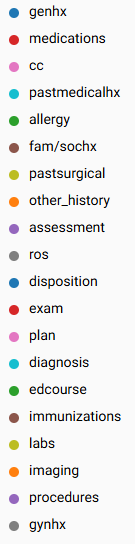

    Visualización  de ELMo

PCA (Principal Component Analysis) y (T-SNE) t-Distributed Stochastic Neighbor Embedding

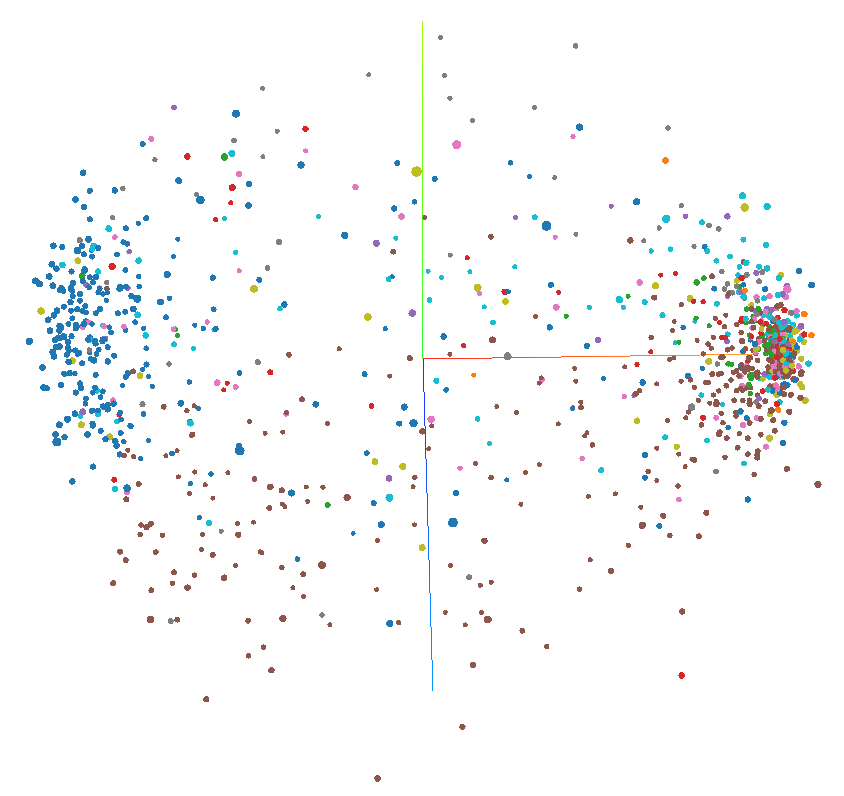 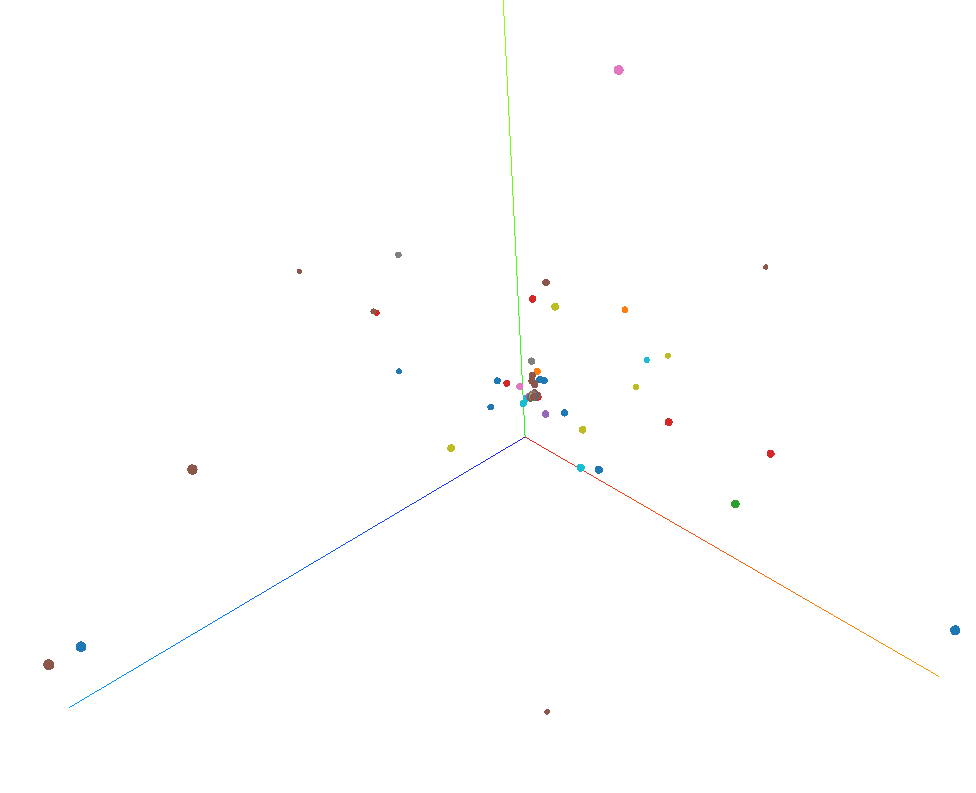

    Visualización de Clinical BERT

PCA (Principal Component Analysis) y (T-SNE) t-Distributed Stochastic Neighbor Embedding

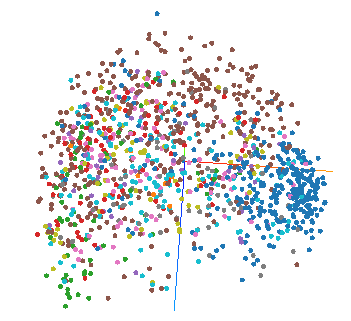 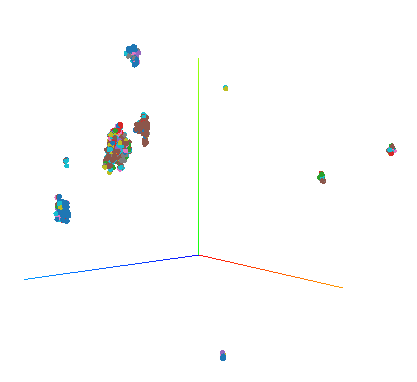

Si comparamos ambos embeddings, ClinicalBERT genera embeddings más compactos y mejor separados por categoría que ELMo, posiblemente debido a que esstá adaptado específicamente a notas clínicas. Especialmente en el t-SNE del Clinical-BERT que parece ser capaz de hacer agrupaciones bastante definidas. Esto puede sugerir que Clinical-BERT logra identificar similitudes en las conversaciones. 

En general ambos muestran claras agrupaciones de puntos azules y marrones, pero el resto no es claro. Esto significa que hay distinción entre grupos, pero no tanto entre secciones como medicación, diagnosis, etc. Aunque sí distinguen el significado, no logran distingir la categoría exacta. 